## Peak finder
Take in csv file of motif distribution for a cell sample. Detect the regions with enrichment of motif counts within a row of motif distribution.

#### Import library

In [32]:
import csv
import math
import numpy as np
from pf_lib1 import find_peaks_and_or_valleys, plot_raw_data, plot_peaks_and_valleys
import argparse
import sys

# Extend  the scroll of Jupyter Notebook
from IPython.core.display import display, HTML
display(HTML("<style>div.output_scroll { height: 300em; }</style>"))


In [33]:
def input_parser():
    '''
    This fuction allows you to choose method you want
    '''
    parser = argparse.ArgumentParser()

    # Motif distribution (MD) method
    parser.add_argument(
        '-m',
        '--Motif_distribution',
        help="This option allows you choose original method",
        required=False
    )

    # Exponential method
    parser.add_argument(
        '-e',
        '--exponential',
        help="This option allows you choose exponential method",
        required=False
    )

    # Self power method
    parser.add_argument(
        '-s',
        '--self_power',
        help="This option allows you choose self powwer method",
        required=False
    )

    # FFT method
    parser.add_argument(
        '-f',
        '--FFT',
        help="This option allows you choose FFT method",
        required=False
    )
    
    # add parser by list because of the limitation of Jupyter Notebook to use argparse
    method_inputs = parser.parse_args(args=["--Motif_distribution","True","--exponential","True","--self_power","True","--FFT","True"])
    
    return method_inputs



#### Process the data to gather statistic and plot the peaks and valley 

In [34]:
# method 2: take exponential
def exp_method(raw_row):
    '''
    This fuction will take exponential of raw data
    
    Parameters
    ---------------
    raw_row            : list
                         This parameter contain raw data list
                         
    Returns
    ---------------
    exp_data           : list
                         This parameter contain list after taking exponential 
    '''
    e = math.exp(1)
    exp_list = np.linspace(e, e, len(raw_row))
    exp_data = np.multiply(exp_list,raw_row)
    return exp_data

# method 3: take self power
def power_method(raw_row):
    '''
    This fuction will take self power of raw data

    Parameters
    ---------------
    raw_row            : list
                         This parameter contain raw data list
                         
    Returns
    ---------------
    power_data           : list
                         This parameter contain list after taking self power 

    '''
    e = math.exp(1)
    power_data = np.multiply(raw_row,raw_row)
    power_data = np.array(power_data, dtype=np.float64)
    return power_data

# method 4: FFT
def FFT_method(raw_row):
    '''
    This fuction will take Fourier transform of raw data
    
    Parameters
    ---------------
    raw_row            : list
                         This parameter contain raw data list
                         
    Returns
    ---------------
    FFT_data           : list
                         This parameter contain list after taking Fourier transform
    '''
    count = 0
    FFT_raw = []
    for i in raw_row:
        #print(raw_row)
        if (float(i)>max(raw_row)*0.5):
            FFT_raw.append(raw_row[count])
        else:
            FFT_raw.append(0)
        count = count + 1
    return FFT_raw




def read_mds_file(file_name):
    '''
    This fuction will read a MD file that uses Joey's MD file format
    
    
    Parameters
    ---------------
    filename           : str
                         This parameter contain the naming of input file
        
    Returns
    ---------------
    raw_data           : list
                         Return the raw data as a list
    exp_data           : list
                         Return the exp data as a list
    power_data         : list
                         Return the self powe data as a list
    FFT_data           : list
                         Return the FFT data as a list
    '''
    
    raw_data = []
    exp_data = []
    power_data = []
    FFT_data = []
    with open(file_name, newline='') as csvfile:
        csv_reader = csv.reader(csvfile, delimiter=',')
        next(csv_reader)
        for row in csv_reader:
            raw_row = [int(value) for value in row[1:]]
            # the above list comprehension is equivalent to:
    #         raw_row = []
    #         for value in row[1:]:
    #             raw_row.append(int(value))
            raw_data.append(raw_row)
       
            # exp method 
            exp_row = exp_method(raw_row)
            exp_data.append(exp_row)
            
            # power method
            power_row = power_method(raw_row)
            power_data.append(power_row)

            # FFT metohd - there are some bugs here
            FFT_row = FFT_method(raw_row)
            FFT_data.append(FFT_row)
            

    return raw_data, exp_data, power_data, FFT_data


In [35]:
def find_peak(raw_row, reduce_size, smooth_size):
    '''
    This fuction will help you find the peak and print out the data
    
    Parameters
    ---------------
    raw_row            : list
                         This parameter contain the raw data
    reduce_size        : int
                         This parameter contain the size of reducing raw data
    smooth_size        : int
                         This parameter contain the size of smoothing raw data
                         
    Returns
    ---------------
    no return but print out the data directly
    
    '''
    reduced_row, peaks, valleys, peak_properties, valley_properties = find_peaks_and_or_valleys(raw_row, reduce_size, smooth_size)
    peaks_bp = []

        
    for old_loc in peaks:
        new_loc = (old_loc + int(smooth_size/2))*reduce_size
        peaks_bp.append(new_loc)
    valleys_bp = []
    for old_loc in valleys:
        new_loc = (old_loc + int(smooth_size/2))*reduce_size
        valleys_bp.append(new_loc)
    plot_raw_data(raw_row, peaks_bp, valleys_bp)
    plot_peaks_and_valleys(reduced_row, peaks, valleys)
    print("---------------------------------------------------")


In [36]:
# TODO config
def find_peak_method(file_name, Motif_distribution, exponential, self_power, FFT):
    '''
    This fuction can let the user choose which method that want to use for finding peak
    
    Parameters
    ---------------
    filename           : str
                         This parameter contain the naming of input file
    Motif_distribution : str
                         This parameter contain whether use Motif_distribution metohd by argparse
    exponential        : str
                         This parameter contain whether use Motif_distribution metohd by argparse
    self_power         : str
                         This parameter contain whether use self_power metohd by argparse
    FFT                : str
                         This parameter contain whether use FFT metohd by argparse
                         
    Returns
    ---------------
    raw_data           : list
                         Store the data
    '''
    reduce_size = 10 
    smooth_size = 10
    
    # transform the 2D lsit
    raw_data = read_mds_file(file_name)
    raw_data=list(map(list,zip(*raw_data)))

    for i in range(len(raw_data)):
        count = 0    
        for raw_row in raw_data[i]:
            # Print which method is based on parser
            if count == 0 and Motif_distribution == "True":
                print("Original Method")
                find_peak(raw_row, reduce_size, smooth_size) 
            elif count == 1 and exponential == "True":
                print("exp method")
                find_peak(raw_row, reduce_size, smooth_size) 
            elif count == 2 and self_power == "True":
                print("power method")
                find_peak(raw_row, reduce_size, smooth_size) 
            elif count == 3 and FFT == "True":
                print("FFT metohd")
                find_peak(raw_row, reduce_size, smooth_size) 
            count = count + 1
    return raw_data

        

Original Method


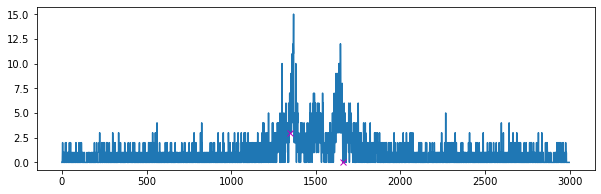

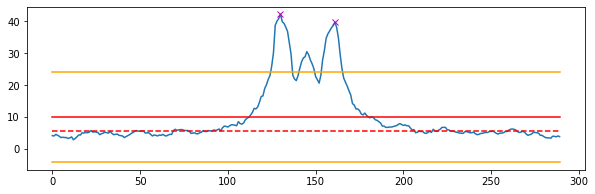

---------------------------------------------------
exp method


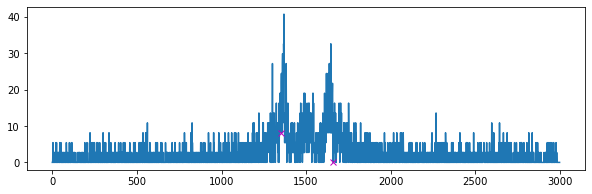

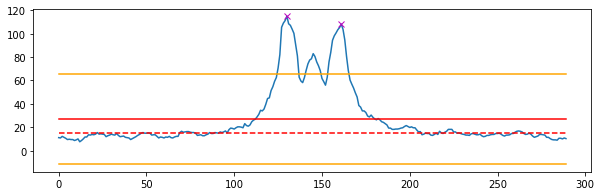

---------------------------------------------------
power method


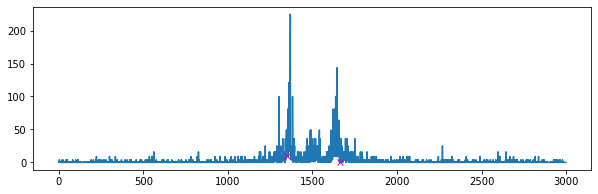

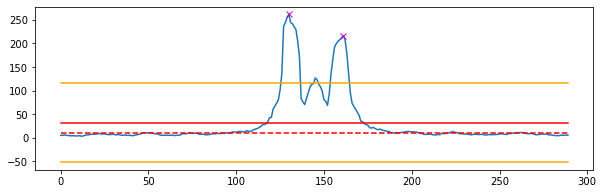

---------------------------------------------------
FFT metohd


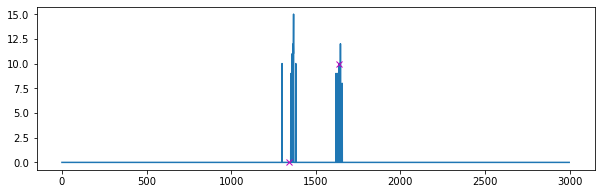

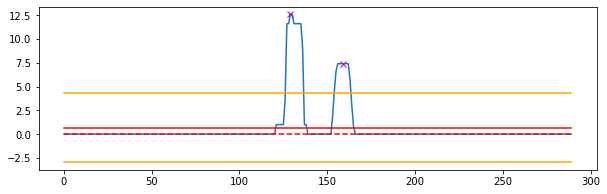

---------------------------------------------------
Original Method


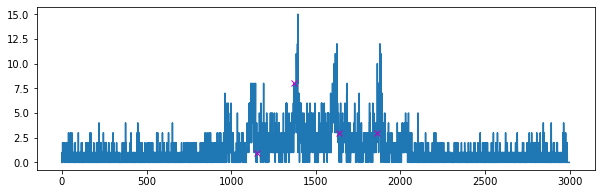

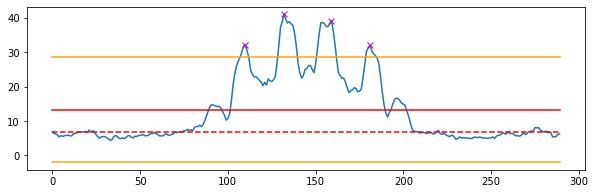

---------------------------------------------------
exp method


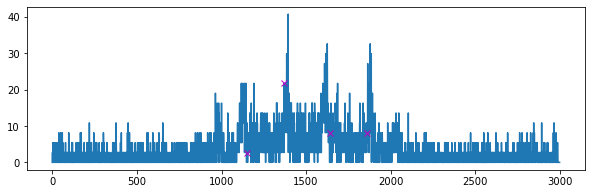

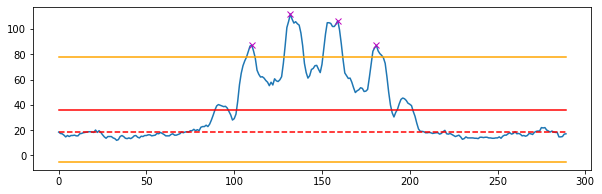

---------------------------------------------------
power method


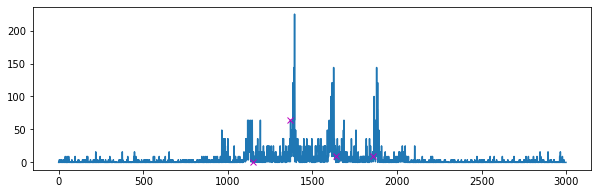

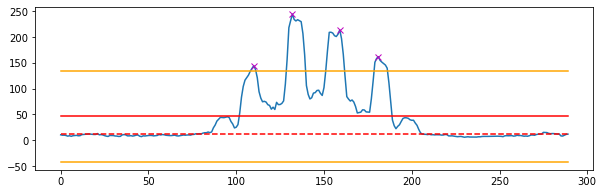

---------------------------------------------------
FFT metohd


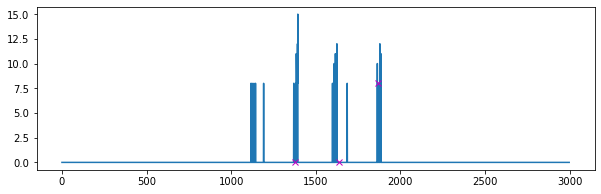

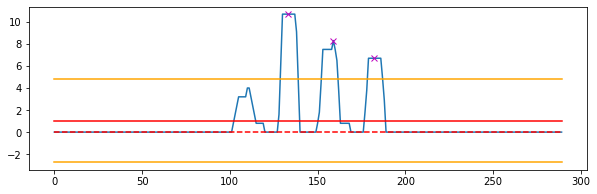

---------------------------------------------------
Original Method


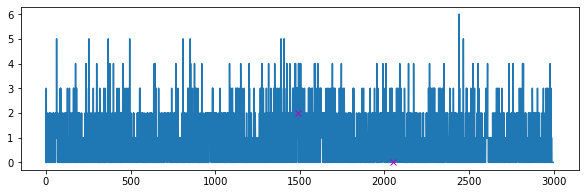

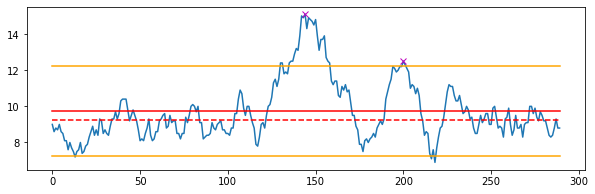

---------------------------------------------------
exp method


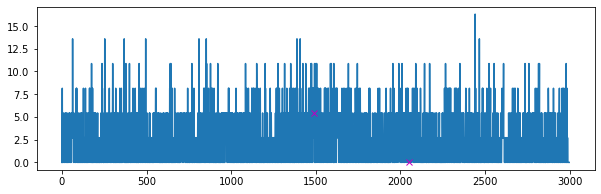

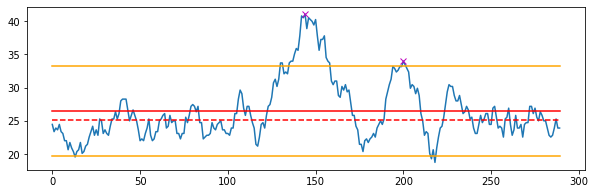

---------------------------------------------------
power method


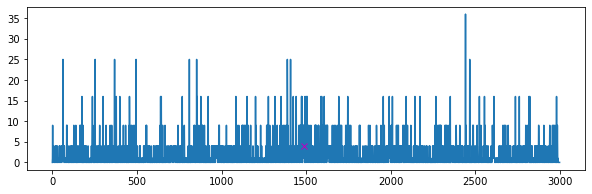

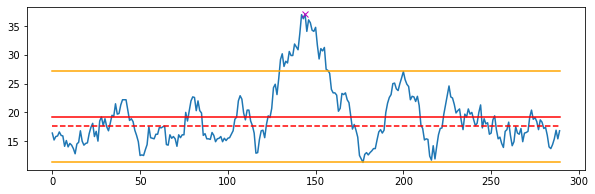

---------------------------------------------------
FFT metohd


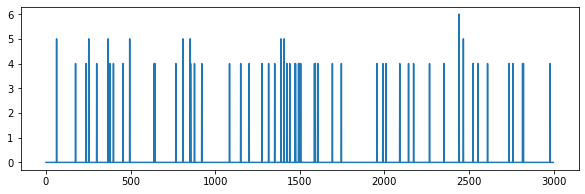

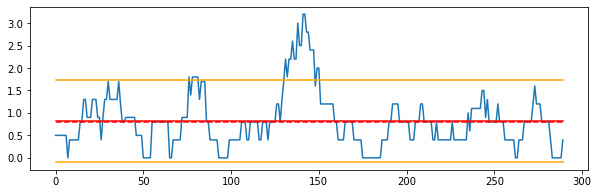

---------------------------------------------------
Original Method


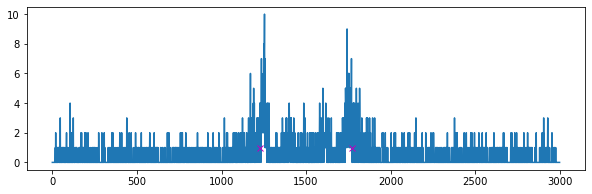

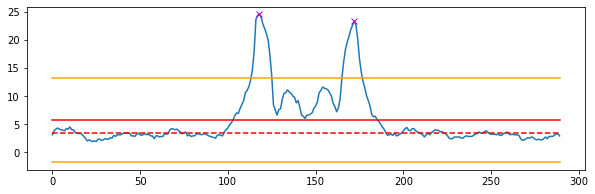

---------------------------------------------------
exp method


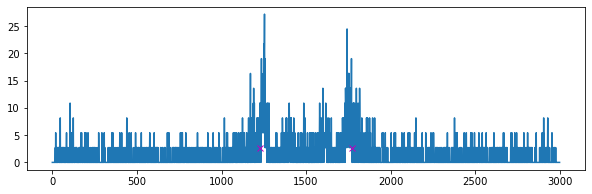

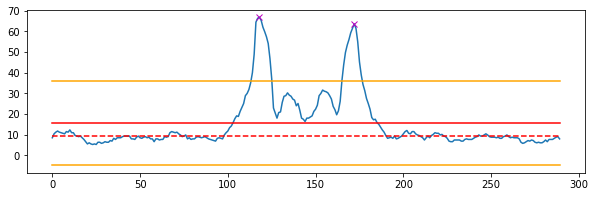

---------------------------------------------------
power method


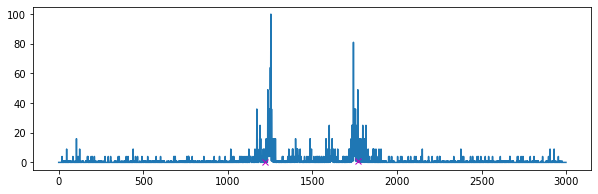

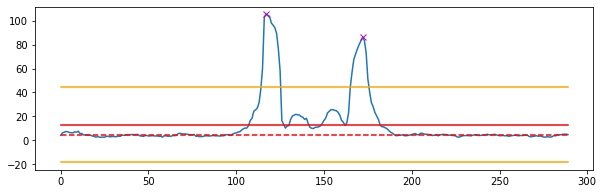

---------------------------------------------------
FFT metohd


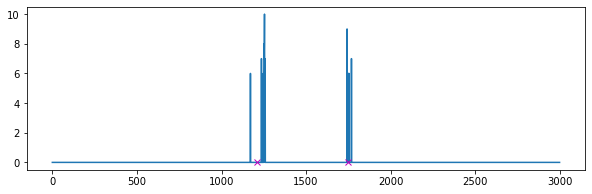

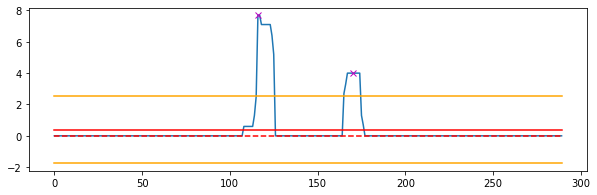

---------------------------------------------------
Original Method


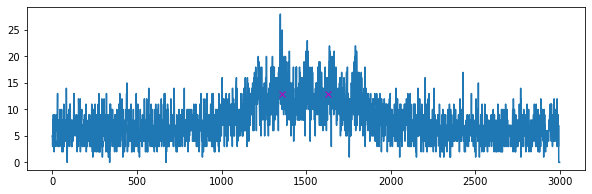

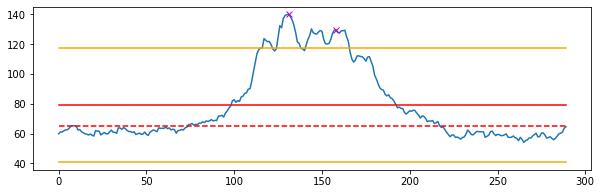

---------------------------------------------------
exp method


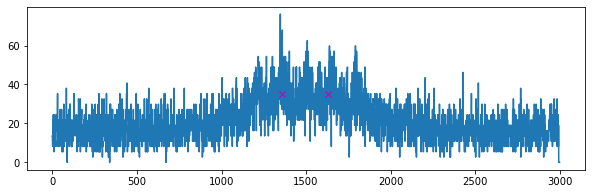

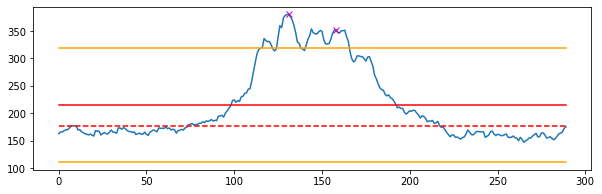

---------------------------------------------------
power method


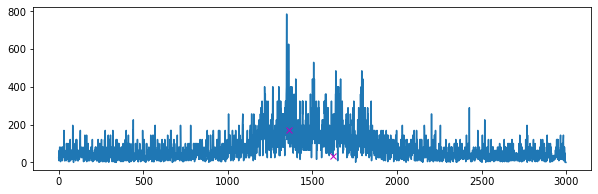

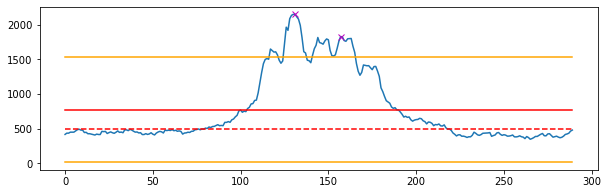

---------------------------------------------------
FFT metohd


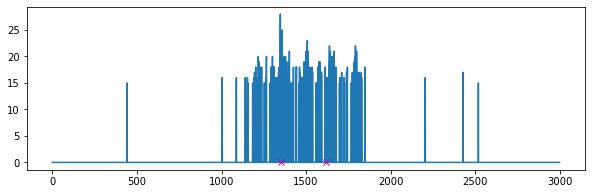

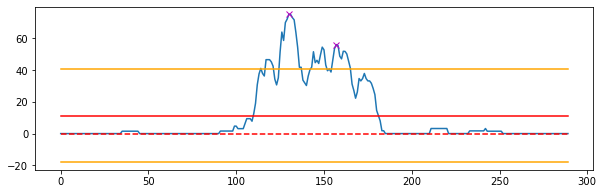

---------------------------------------------------
Original Method


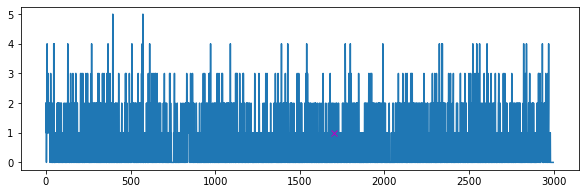

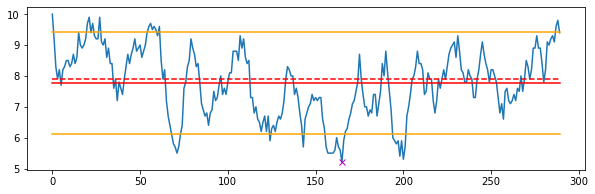

---------------------------------------------------
exp method


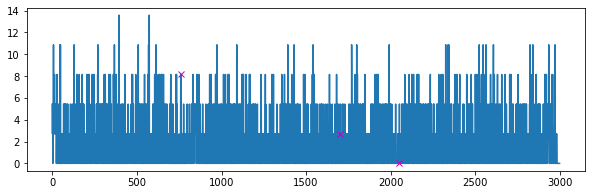

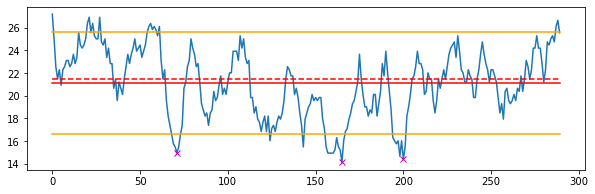

---------------------------------------------------
power method


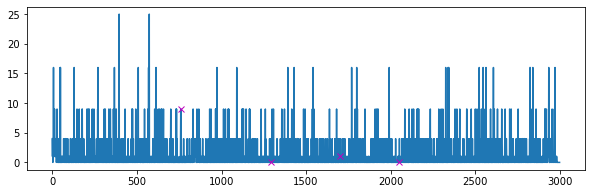

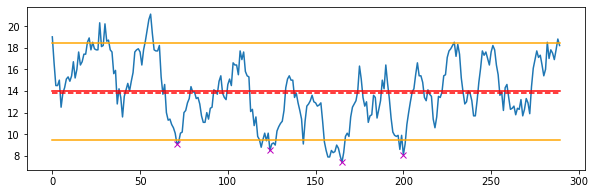

---------------------------------------------------
FFT metohd


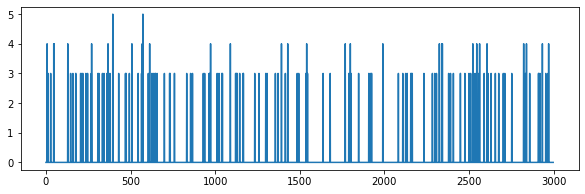

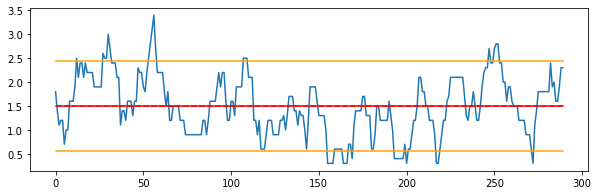

---------------------------------------------------
Original Method


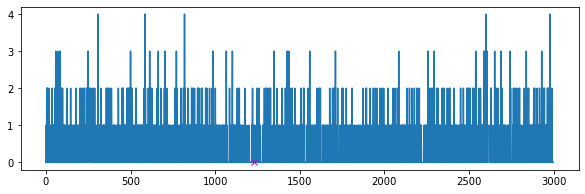

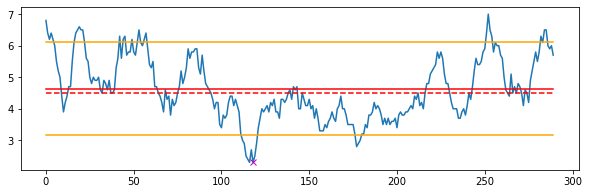

---------------------------------------------------
exp method


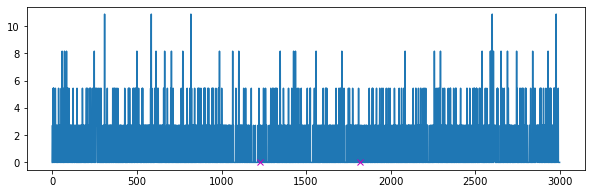

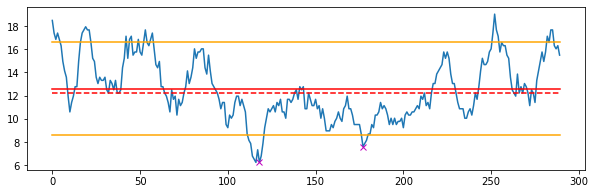

---------------------------------------------------
power method


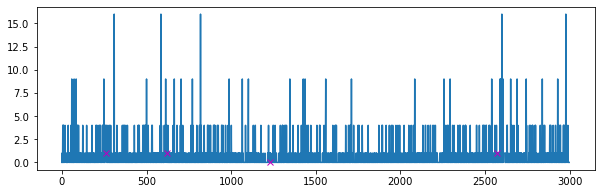

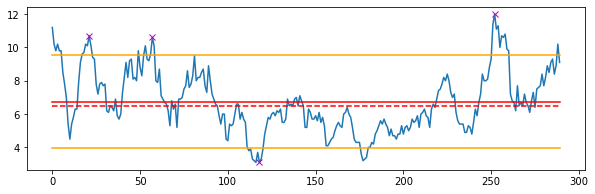

---------------------------------------------------
FFT metohd


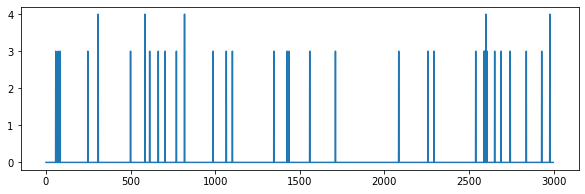

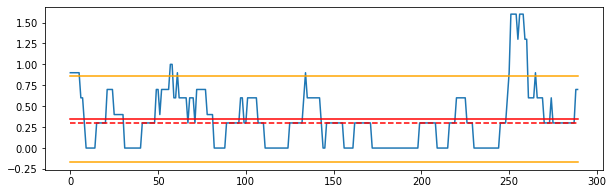

---------------------------------------------------
Original Method


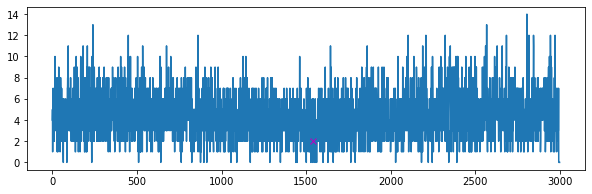

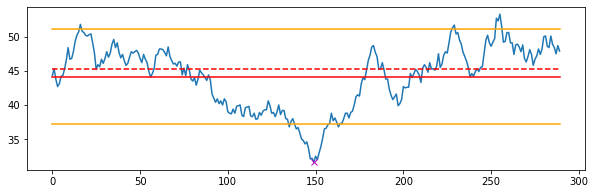

---------------------------------------------------
exp method


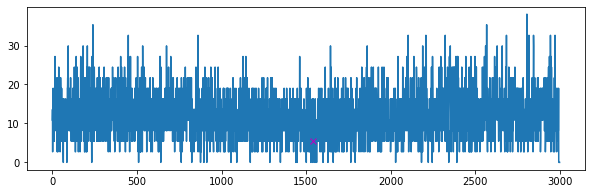

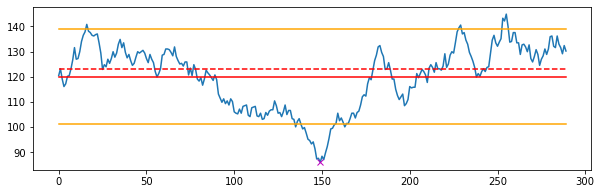

---------------------------------------------------
power method


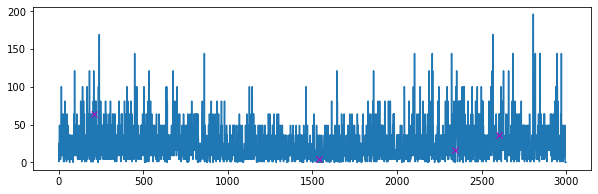

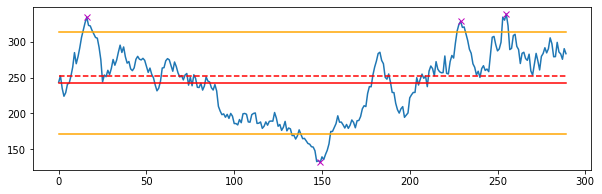

---------------------------------------------------
FFT metohd


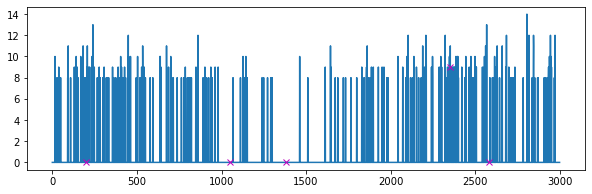

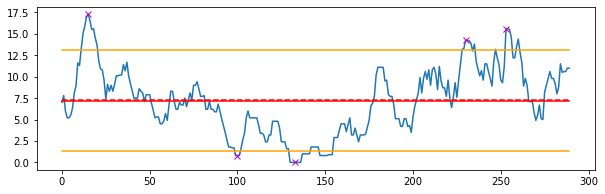

---------------------------------------------------
Original Method


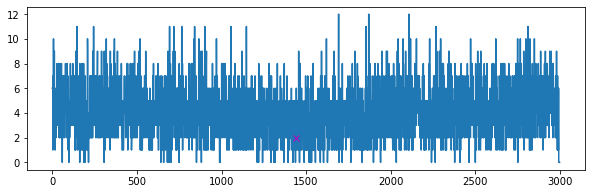

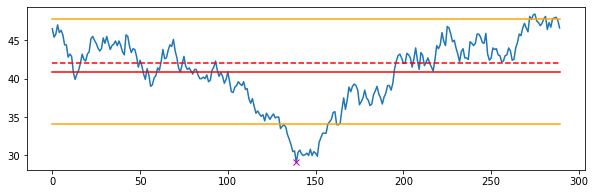

---------------------------------------------------
exp method


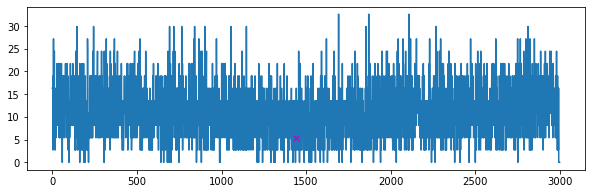

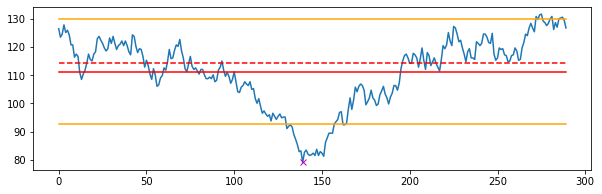

---------------------------------------------------
power method


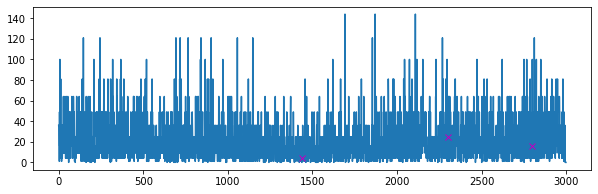

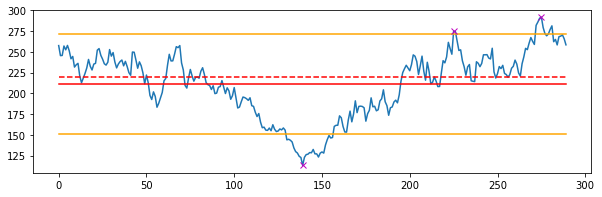

---------------------------------------------------
FFT metohd


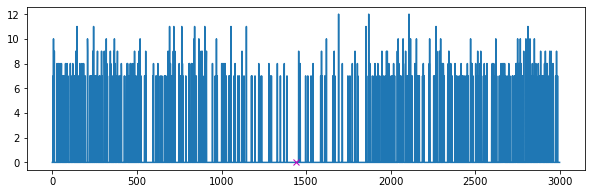

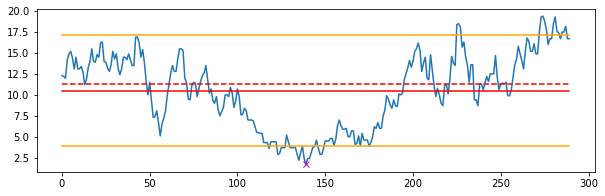

---------------------------------------------------
Original Method


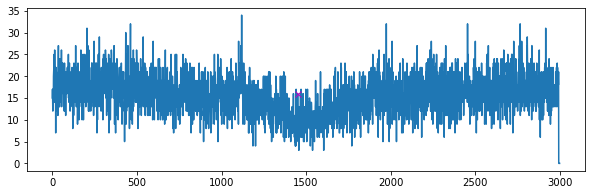

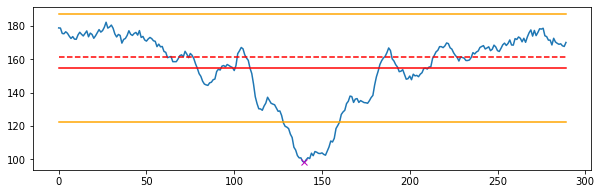

---------------------------------------------------
exp method


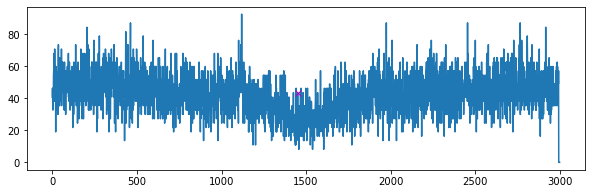

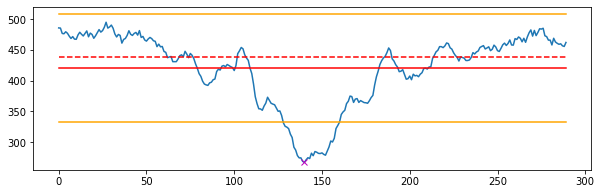

---------------------------------------------------
power method


In [ ]:
def main():
    '''
    Find the peak by  input of argparse
    '''

    my_args = input_parser()
    # get the input from argparse
    Motif_distribution = my_args.Motif_distribution
    exponential = my_args.exponential
    self_power = my_args.self_power
    FFT = my_args.FFT
    
    #trigger the func
    file_name = 'SRR574824_filtereddata.csv'
    find_peak_method(file_name, Motif_distribution, exponential, self_power, FFT)

if __name__ == "__main__":
    main()
    

StdDev:  6.059332717013568 , 1.5 StdDev:  9.088999075520352 ,2.0 StdDev:  12.118665434027136
Peak properties:  {'peak_heights': array([131. , 147.3]), 'prominences': array([ 7.4, 34.3]), 'left_bases': array([123, 123]), 'right_bases': array([139, 290]), 'widths': array([ 5.58333333, 12.02113527]), 'width_heights': array([127.3 , 130.15]), 'left_ips': array([130.16666667, 158.07608696]), 'right_ips': array([135.75      , 170.09722222])}


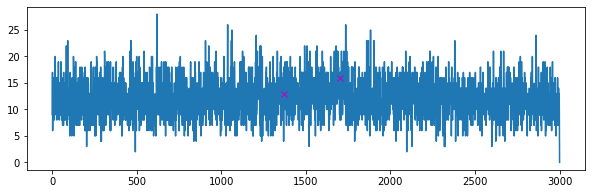

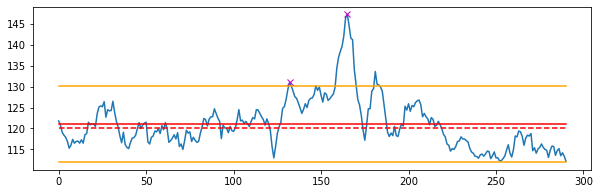

StdDev:  1.916588389772906 , 1.5 StdDev:  2.8748825846593586 ,2.0 StdDev:  3.833176779545812
Peak properties:  {'peak_heights': array([36.2]), 'prominences': array([10.9]), 'left_bases': array([65]), 'right_bases': array([209]), 'widths': array([19.23076923]), 'width_heights': array([30.75]), 'left_ips': array([154.26923077]), 'right_ips': array([173.5])}
Valley properties:  {'peak_heights': array([10.9, 13.2]), 'prominences': array([7., 9.]), 'left_bases': array([ 48, 164]), 'right_bases': array([164, 260]), 'widths': array([20.54545455, 12.82142857]), 'width_heights': array([7.4, 8.7]), 'left_ips': array([ 57.36363636, 201.42857143]), 'right_ips': array([ 77.90909091, 214.25      ])}


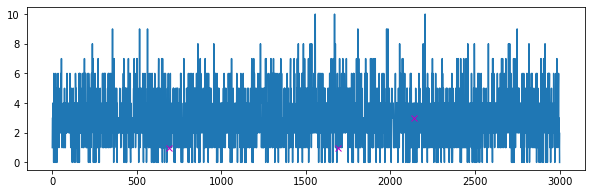

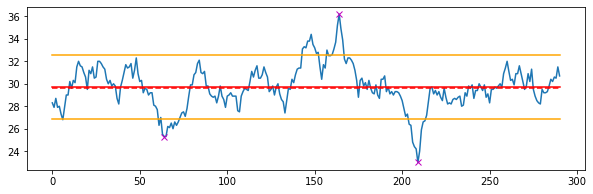

StdDev:  1.6701299483327778 , 1.5 StdDev:  2.5051949224991668 ,2.0 StdDev:  3.3402598966655557
Peak properties:  {'peak_heights': array([25.4, 27.2, 25.9]), 'prominences': array([4.9, 6.6, 4.2]), 'left_bases': array([ 11, 156, 245]), 'right_bases': array([156, 268, 268]), 'widths': array([11.81818182, 18.70833333,  9.2       ]), 'width_heights': array([22.95, 23.9 , 23.8 ]), 'left_ips': array([ 70.43181818, 221.625     , 250.5       ]), 'right_ips': array([ 82.25      , 240.33333333, 259.7       ])}
Valley properties:  {'peak_heights': array([7.8, 8.6, 8.5]), 'prominences': array([5.6, 6.8, 5.4]), 'left_bases': array([ 80,  80, 171]), 'right_bases': array([136, 230, 230]), 'widths': array([10.55555556, 16.97115385, 15.45384615]), 'width_heights': array([5. , 5.2, 5.8]), 'left_ips': array([ 84.33333333, 144.875     , 199.7       ]), 'right_ips': array([ 94.88888889, 161.84615385, 215.15384615])}


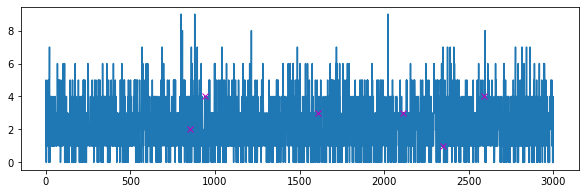

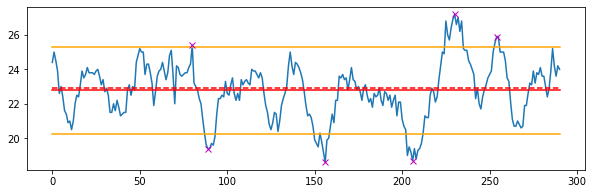

StdDev:  1.5227162476007898 , 1.5 StdDev:  2.284074371401185 ,2.0 StdDev:  3.0454324952015797
Peak properties:  {'peak_heights': array([30.3, 30.6, 30. ]), 'prominences': array([5.4, 6.4, 4.6]), 'left_bases': array([  7,  32, 209]), 'right_bases': array([ 32, 209, 257]), 'widths': array([10.96153846, 17.70833333, 13.35294118]), 'width_heights': array([27.6, 27.4, 27.7]), 'left_ips': array([ 17.        ,  90.66666667, 227.        ]), 'right_ips': array([ 27.96153846, 108.375     , 240.35294118])}
Valley properties:  {'peak_heights': array([6.4, 8.8]), 'prominences': array([6.1, 8.2]), 'left_bases': array([22, 97]), 'right_bases': array([ 97, 220]), 'widths': array([ 7.06944444, 19.03636364]), 'width_heights': array([3.35, 4.7 ]), 'left_ips': array([ 28.625     , 193.36363636]), 'right_ips': array([ 35.69444444, 212.4       ])}


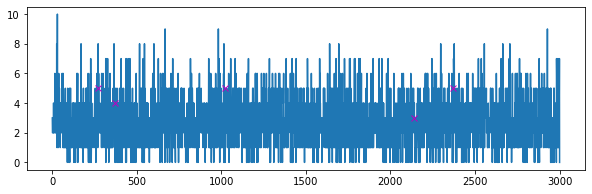

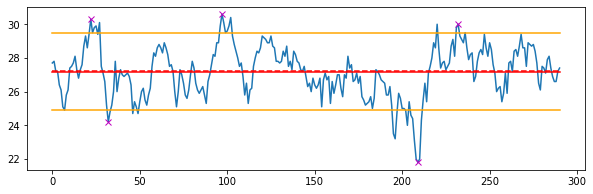

StdDev:  11.666437145000755 , 1.5 StdDev:  17.49965571750113 ,2.0 StdDev:  23.33287429000151
Peak properties:  {'peak_heights': array([84.7]), 'prominences': array([37.7]), 'left_bases': array([1]), 'right_bases': array([285]), 'widths': array([119.59722222]), 'width_heights': array([65.85]), 'left_ips': array([103.875]), 'right_ips': array([223.47222222])}


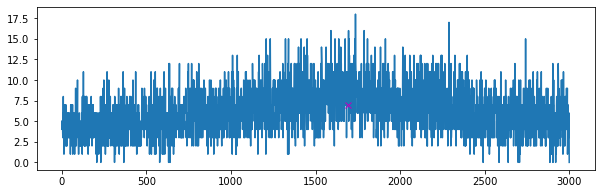

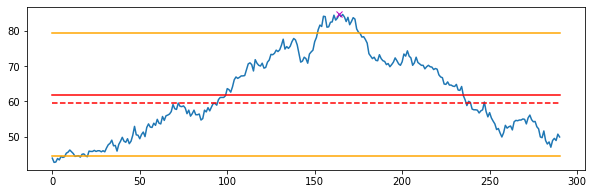

In [ ]:
#### New MDS
# TODO config
file_name = 'SRR574824_new_md_table.csv'
reduce_size = 10 
smooth_size = 10

raw_data = read_mds_file(file_name)
    
for raw_row in raw_data:
    reduced_row, peaks, valleys, peak_properties, valley_properties = find_peaks_and_or_valleys(raw_row, reduce_size, smooth_size)
    peaks_bp = []
    for old_loc in peaks:
        new_loc = (old_loc + int(smooth_size/2))*reduce_size
        peaks_bp.append(new_loc)
    valleys_bp =[]
    for old_loc in valleys:
        new_loc = (old_loc + int(smooth_size/2))*reduce_size
        valleys_bp.append(new_loc)
    plot_raw_data(raw_row, peaks_bp, valleys_bp)
    plot_peaks_and_valleys(reduced_row, peaks, valleys)

In [15]:
file_name = 'joey.csv'
reduce_size = 10 
smooth_size = 10

raw_data = read_mds_file(file_name)
    
for raw_row in raw_data:
    reduced_row, peaks, valleys, peak_properties, valley_properties = find_peaks_and_or_valleys(raw_row, reduce_size, smooth_size)
    peaks_bp = []
    for old_loc in peaks:
        new_loc = (old_loc + int(smooth_size/2))*reduce_size
        peaks_bp.append(new_loc)
    valleys_bp =[]
    for old_loc in valleys:
        new_loc = (old_loc + int(smooth_size/2))*reduce_size
        valleys_bp.append(new_loc)
    plot_raw_data(raw_row, peaks_bp, valleys_bp)
    plot_peaks_and_valleys(reduced_row, peaks, valleys)

StatisticsError: mean requires at least one data point